In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from scipy import stats
from scipy import optimize

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv("../data/wholetime.csv")
df_sample = df.sample(100000)

In [5]:
df_sample.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
10605621,41.884616,-87.644571,15535,Desplaines St & Randolph St,2023-06-20 09:46:20,member,ACC9BDB5BCA1D90F,electric_bike,41.907711,-87.672548,13221,Wood St & Milwaukee Ave,2023-06-20 09:37:25,3.459803,"(41.9077105, -87.67254816666667)","(41.88461618962, -87.6445705849)"
5433095,41.902309,-87.627691,KA1504000133,Rush St & Cedar St,2022-06-09 06:40:39,member,183F51DF0C1CE54E,electric_bike,41.911305,-87.638736,TA1307000038,Sedgwick St & North Ave,2022-06-09 06:32:14,1.355820,"(41.911304712, -87.638735652)","(41.90230870122, -87.627690528)"
17568779,41.876511,-87.620548,15541,Buckingham Fountain,2021-06-22 19:59:40,casual,5638E84738120BCF,classic_bike,41.890573,-87.622072,13427,Cityfront Plaza Dr & Pioneer Ct,2021-06-22 18:01:37,1.566969,"(41.890573, -87.622072)","(41.87651122881695, -87.62054800987242)"
10201774,41.943670,-87.648950,TA1309000025,Halsted St & Roscoe St,2023-05-05 17:02:41,casual,3833F202D78A1288,electric_bike,41.961607,-87.654601,TA1307000107,Sheridan Rd & Montrose Ave,2023-05-05 16:57:17,2.046683,"(41.961607218, -87.654601097)","(41.94367, -87.64895)"
7412544,41.890847,-87.618617,TA1306000013,New St & Illinois St,2022-09-20 10:57:11,member,1D50995C021BB420,electric_bike,41.902465,-87.627610,KA1504000133,Rush St & Cedar St,2022-09-20 10:51:02,1.490686,"(41.902465, -87.62761)","(41.89084704062381, -87.61861681938171)"


In [4]:
df_sample = df.sample(10000000)
df_sample = df_sample[df_sample['distance'] > 0]

Text(0.5, 1.0, 'Histogram of Distance')

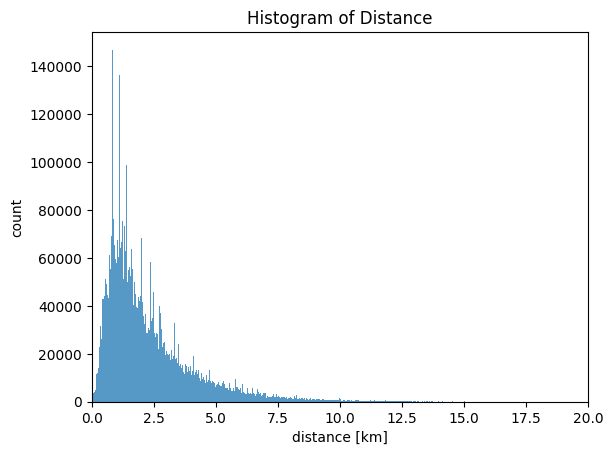

In [16]:
# distanceでヒストグラム
fig, ax = plt.subplots(1, 1, dpi=100)
ax = sns.histplot(
    data = df_sample,
    x = "distance"
)
ax.set_xlabel("distance [km]")
ax.set_ylabel("count")
ax.set_xlim(0, 20)
ax.set_title("Histogram of Distance")

In [5]:
# Get the node_, edge_list and timestamp
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_ = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_にはユニークなstart_station_idを追加
        node_.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_とedge_listで0の値を削除
    active_node_list = np.array(node_)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_ = node_[node_ != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_)]
    
    return active_node_list, edge_list, timestamp

In [6]:
sample_node, sample_edge, sample_timestamp = return_nm(df_sample)

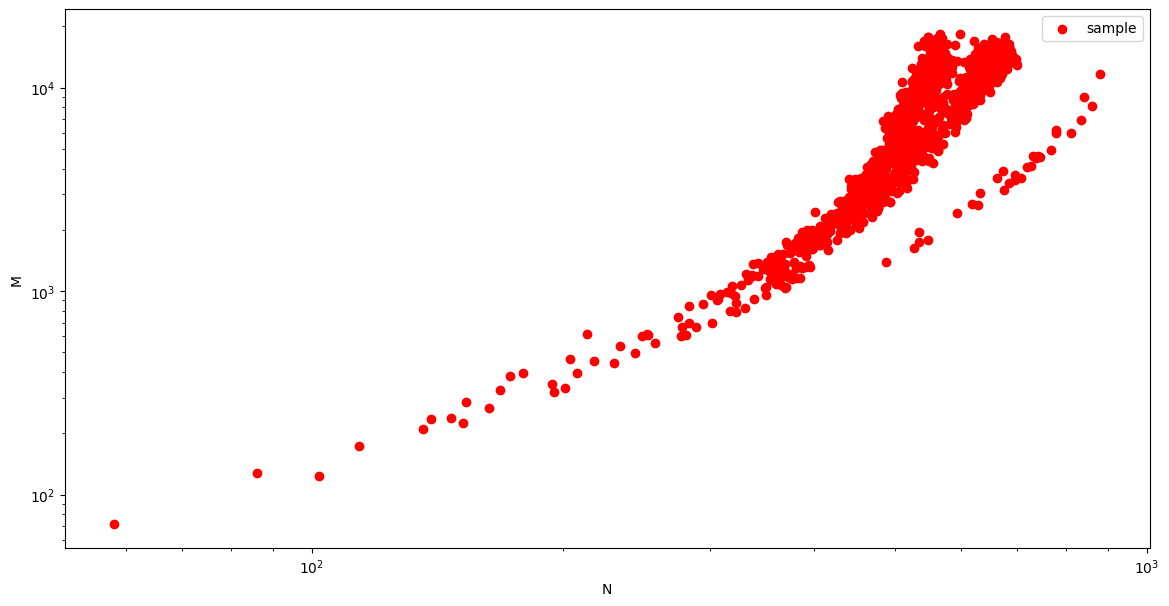

In [19]:
color_list = ['red', 'blue', 'green', 'orange']

plt.figure(figsize=(14, 7))
plt.scatter(sample_node, sample_edge,label='sample', color=color_list[0])
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [7]:
# df_sampleを年代別に分割
df_sample_2020 = df_sample[(df_sample['started_at'] >= '2020-03-01') & (df_sample['started_at'] < '2020-06-01')]
df_sample_2020_2 = df_sample[(df_sample['started_at'] >= '2020-06-01') & (df_sample['started_at'] < '2020-11-01')]
df_sample_2020_2021 = df_sample[(df_sample['started_at'] >= '2020-12-01') & (df_sample['started_at'] < '2021-03-01')]
# df_sample_2020_2021のうち、11月分のデータは外す
df_sample_2021 = df_sample[(df_sample['started_at'] >= '2021-03-01') & (df_sample['started_at'] < '2022-01-01')]
df_sample_2022 = df_sample[(df_sample['started_at'] >= '2022-01-01') & (df_sample['started_at'] < '2023-01-01')]
df_sample_2023 = df_sample[(df_sample['started_at'] >= '2023-01-01') & (df_sample['started_at'] < '2024-01-01')]

In [8]:
color_list = ['red', 'blue', 'green', 'orange', 'purple', 'black']

In [9]:
node_2020, edge_2020, timestamp_2020 = return_nm(df_sample_2020)
node_2020_2, edge_2020_2, timestamp_2020_2 = return_nm(df_sample_2020_2)
node_2020_2021, edge_2020_2021, timestamp_2020_2021 = return_nm(df_sample_2020_2021)
node_2021, edge_2021, timestamp_2021 = return_nm(df_sample_2021)
node_2022, edge_2022, timestamp_2022 = return_nm(df_sample_2022)
node_2023, edge_2023, timestamp_2023 = return_nm(df_sample_2023)

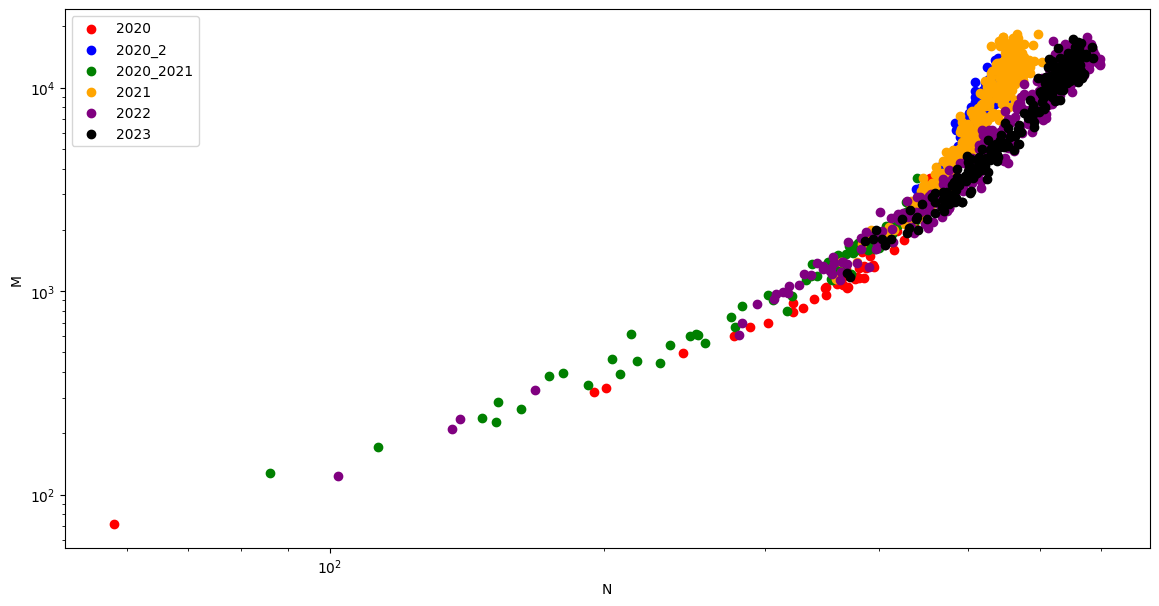

In [29]:
plt.figure(figsize=(14, 7))
plt.scatter(node_2020, edge_2020,label='2020', color=color_list[0])
plt.scatter(node_2020_2, edge_2020_2,label='2020_2', color=color_list[1])
plt.scatter(node_2020_2021, edge_2020_2021,label='2020_2021', color=color_list[2])
plt.scatter(node_2021, edge_2021,label='2021', color=color_list[3])
plt.scatter(node_2022, edge_2022,label='2022', color=color_list[4])
plt.scatter(node_2023, edge_2023,label='2023', color=color_list[5])
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

## サンプリングしたものを2つに分解する

In [10]:
# dfを2つに分解する
sam_2020_2021 = df_sample[(df_sample['started_at'] >= '2020-03-01') & (df_sample['started_at'] < '2021-12-01')].dropna()
sam_2022_2023 = df_sample[(df_sample['started_at'] >= '2022-01-01') & (df_sample['started_at'] < '2023-10-01')].dropna()

# df_2020_2021から2020-11-01から2020-11-30のデータを削除する
sam_2020_2021 = sam_2020_2021[(sam_2020_2021['started_at'] < '2020-11-01') | (sam_2020_2021['started_at'] >= '2020-12-01')]

In [11]:
node_2020_2021, edge_2020_2021, timestamp_2020_2021 = return_nm(sam_2020_2021)
node_2022_2023, edge_2022_2023, timestamp_2022_2023 = return_nm(sam_2022_2023)

In [17]:
print(len(node_2020_2021))
print(len(edge_2020_2021))

609
577


ValueError: x and y must be the same size

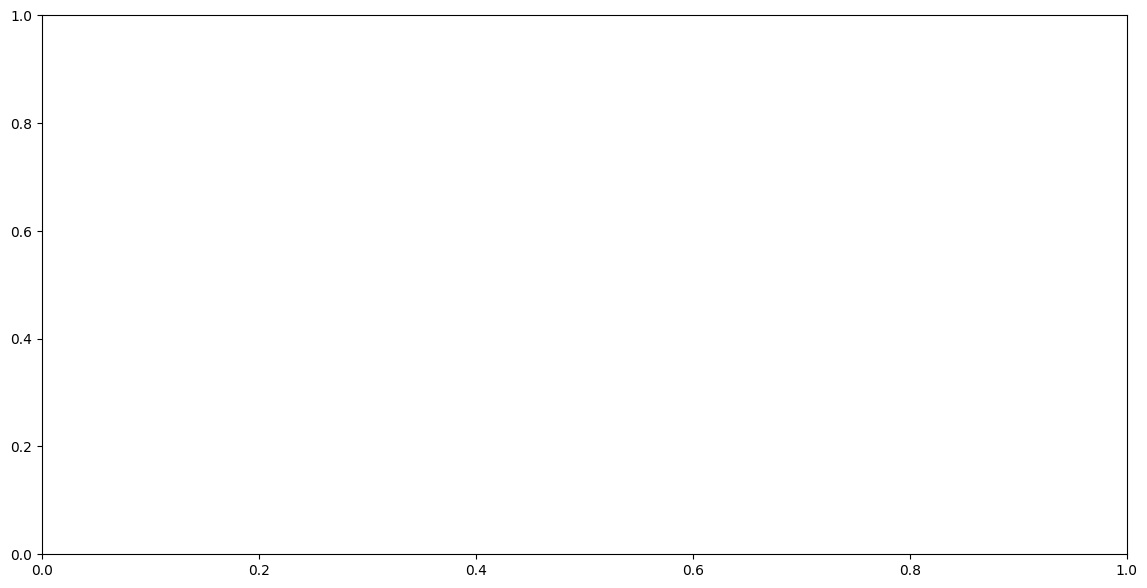

In [12]:
plt.figure(figsize=(14, 7))
plt.scatter(node_2020_2021, edge_2020_2021,label='2020, 2021', color=color_list[0])
plt.scatter(node_2022_2023, edge_2022_2023,label='2022, 2023', color=color_list[1])
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [13]:
"""
Kobayashi & Génois (2021)のモデルを用いて、計算する
"""
def model1(m, m0, kappa):
    Np = (1 + np.sqrt(1 + ((32*m0) / kappa))) / 2
    res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )
    if res.any() < 0:
        return 0
    else:
        return res
    
def model2(m, m0, Np):
    kappa = 8*m0/(Np**2-Np)
    res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))
    if res.any() < 0:
        return 0
    else:
        return res
    
def calc_N(Np, kappa):
    return Np * (1 - (2 / (kappa * Np))*(1 - (1 - (kappa / 2))**Np))

def calc_M(Np, kappa):
    return (kappa * Np * (Np - 1)) / 8

In [14]:
# 初期値を探す for model2
# 初期値の範囲を設定
init_m0_range = [1, 2000]
init_Np_range = [1, 5400]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(100):
    init_m0 = np.random.uniform(*init_m0_range)
    init_Np = np.random.uniform(*init_Np_range)
    

    popt, pcov = optimize.curve_fit(model2, edge_2020_2021, node_2020_2021, p0=[init_m0, init_Np])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_2020_2021 - model2(edge_2020_2021, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit2 = popt

print(best_fit2)  # 最良のフィットパラメータを表示
m0_init2 = best_fit2[0]
Np_init2 = best_fit2[1]

[368.80628202 822.86664814]


In [15]:
N_fit2 = []
M_fit2 = []
popt2, pcov2 = optimize.curve_fit(model2, edge_2020_2021, node_2020_2021, p0=[m0_init2, Np_init2])
print("model2: ", popt2)
Np2 = popt2[1]
kappa2 = []
for i in range(len(edge_2020_2021)):
    kappa2.append(8*edge_2020_2021[i]/(Np2**2-Np2))

for i in range(len(node_2020_2021)):
    N_fit2.append(calc_N(Np2, kappa2[i]))

for i in range(len(edge_2020_2021)):
    M_fit2.append(calc_M(Np2, kappa2[i]))

model2:  [368.80628202 822.86664814]


IndexError: list index out of range

ValueError: x and y must be the same size

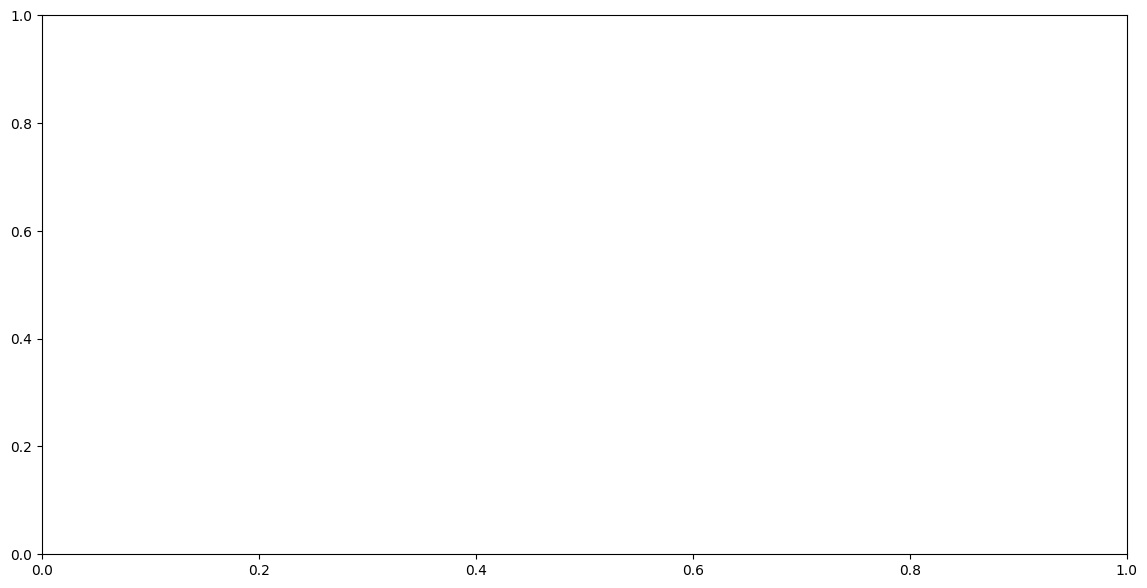

In [16]:
# プロット
nn = len(node_2020_2021)
xmin = min(node_2020_2021)
xmax = max(node_2020_2021)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

plt.figure(figsize=(14, 7))
plt.scatter(node_2020_2021, edge_2020_2021, label='2020/03/01-2021/10/31', color=color_list[0])
#plt.scatter(N_fit, M_fit, label='model1', marker='x')
plt.scatter(N_fit2, M_fit2, label='model2', marker='^')
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

## N-D

In [49]:
def getNodeDistance(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node = []
    distance = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_にはユニークなstart_station_idを追加
        node.append(len(df_tmp['start_station_id'].unique()))
        distance.append(df_tmp['distance'].mean())   

        current_timestamp = next_timestamp

    # node_とedge_listで0の値を削除
    node = np.array(node)
    distance = np.array(distance)

    # NaNは削除
    node = node[~np.isnan(distance)]
    distance = distance[~np.isnan(distance)]
    timestamp = timestamp[:len(node)]

    return node, distance, timestamp

In [50]:
sample_n, sample_d, sample_t = getNodeDistance(df_sample)

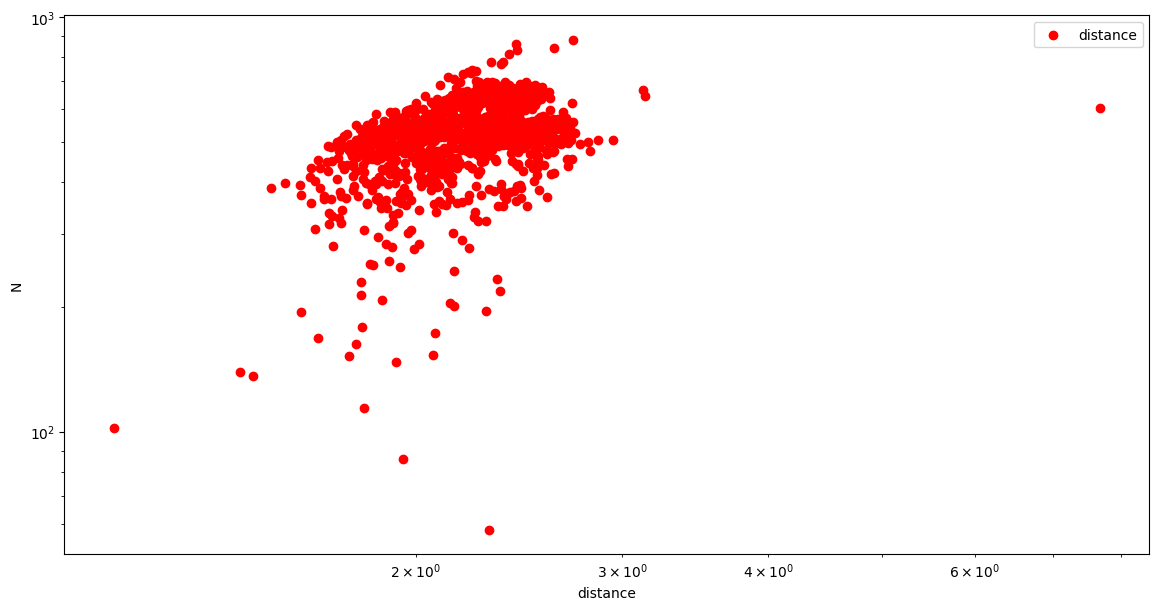

In [75]:
plt.figure(figsize=(14, 7))
plt.scatter(sample_d,sample_n,label='distance', color=color_list[0])
plt.xlabel('distance')
plt.ylabel('N')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [68]:
# sigmiod関数を定義
def sigmoid(x, x0):
    return 1 / (1 + np.exp(-x0))

In [69]:
# 初期値を探す
# 初期値の範囲を設定
init_x_range = [1, 100]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(100):
    init_x = np.random.uniform(*init_x_range)
    

    popt, pcov = optimize.curve_fit(sigmoid, sample_d, sample_n, p0=[init_x])

    # フィットの良さ（二乗誤差）を計算
    residuals = sample_d - sigmoid(sample_n, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit = popt

print(best_fit)  # 最良のフィットパラメータを表示
x_init = best_fit[0]



[84.3985974]


[84.3985974]


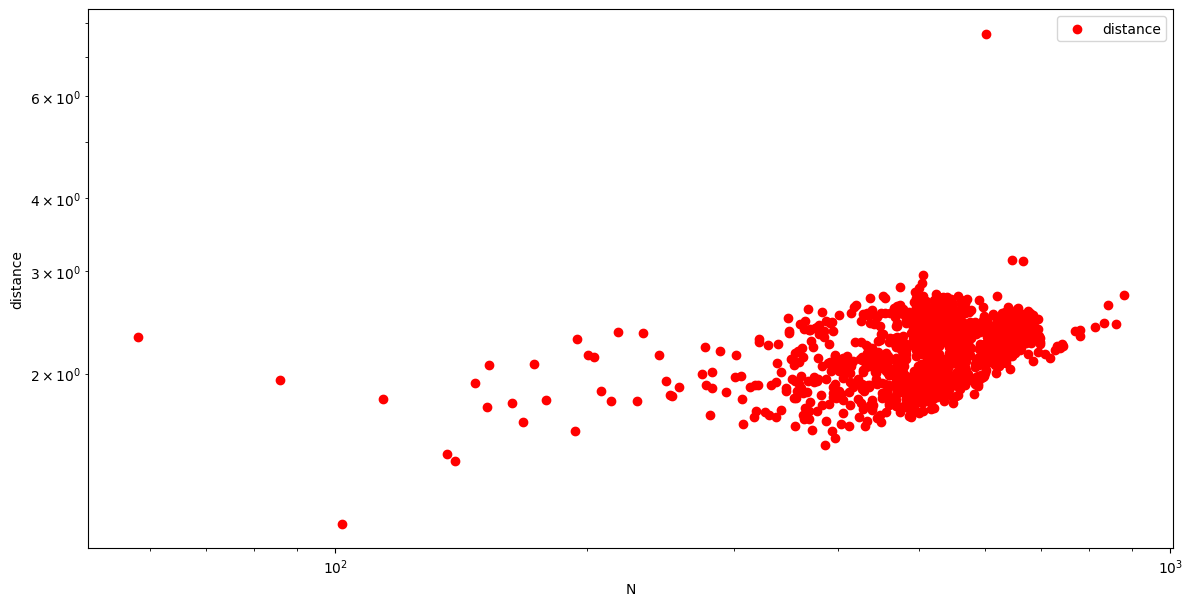

In [76]:
# フィッティング
popt, pcov = optimize.curve_fit(sigmoid, sample_d, sample_n, p0=[x_init])
print(popt)

# プロット
nn = len(sample_n)
xmin = min(sample_n)
xmax = max(sample_n)
p = np.linspace(xmin, xmax, nn)
plt.figure(figsize=(14, 7))
plt.scatter(sample_n, sample_d, label='distance', color=color_list[0])
# plt.plot(p, sigmoid(p, popt), label='sigmoid', marker='x')
plt.xlabel('N')
plt.ylabel('distance')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

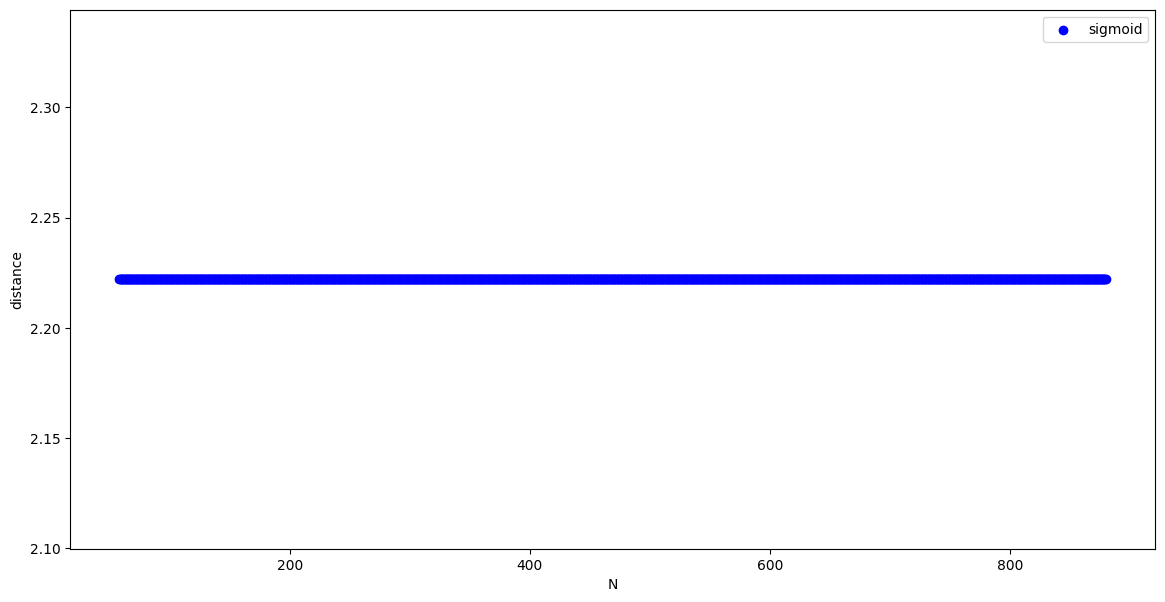

In [60]:
plt.figure(figsize=(14, 7))
#plt.scatter(sample_n, sample_d, label='distance', color=color_list[0])
plt.scatter(p, sigmoid(p, *popt), label='sigmoid', color=color_list[1])
plt.xlabel('N')
plt.ylabel('distance')
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.show()